# Network_traffic_classification – Data Partitioning  

**Author:** Marco Antonio García Sánchez  
**Objective:** Partition the KDDTrain+ dataset into training, validation, and test sets while preserving categorical distributions for intrusion detection modeling.  
**Dataset:** [KDDTrain+ ARFF Dataset](https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) – 125,973 network connection records labeled as `normal` or `anomaly`.  

---

**Original source / credit:**  
This notebook is based on the Udemy course: **"Machine Learning y Data Science: Curso Completo con Python"**  
- **Instructor:** [Santiago Hernández](https://www.udemy.com/user/shramos/) – Expert in Cybersecurity and Artificial Intelligence  
- **Website:** [techmind.ac](https://techmind.ac/)  
- **Course URL:** [udemy.com/course/machine-learning-desde-cero/learn/lecture/19203726](http://udemy.com/course/machine-learning-desde-cero/learn/lecture/19203726)  

**Modifications and improvements:**  
- Reorganized sections for clarity and reproducibility.  
- Added **detailed Markdown documentation** in English and Spanish.  
- Performed **data partitioning**:  
  - Split the dataset into training (60%), validation (20%), and test (20%) subsets.  
  - Used **stratified sampling** to maintain the proportion of the categorical variable `protocol_type` across all subsets.  
  - Ensured reproducibility with a fixed random seed.  
- Conducted **visual checks** using histograms to confirm stratified distributions and avoid sampling bias.  
- Prepared the dataset for **next steps in machine learning**: pipeline creation, feature engineering, and model training.  
- Standardized code and documentation for **GitHub repository presentation**.  

---

📌 **Note:**  
This work represents the **second part** of my project on **network traffic classification**. The **first part (Data Cleaning & Preprocessing)** is available in my GitHub repository:  

- **Notebook:** [1.- Preprocessing_data_in_network_traffic_classification_example.ipynb](https://github.com/MarcoAntonioGarcia/Data-Science-Projects/blob/main/2.-Data%20Cleaning%20%26%20Preprocessing/Preprocessing_data_in_network_traffic_classification_example/1.-Preprocessing_data_in_network_traffic_classification_example.ipynb)   

---

This notebook is part of my **Machine Learning portfolio on GitHub** and demonstrates the workflow from **raw network data preprocessing** (Part 1) to **stratified dataset partitioning** (Part 2), preparing the foundation for feature engineering, pipeline design, and model training.  

### KDD ’99 and NSL-KDD Datasets  

#### About the KDD ’99 Dataset  

The **KDD ’99 dataset** is one of the most widely used benchmark datasets in cybersecurity research, especially for evaluating machine learning–based **Intrusion Detection Systems (IDS)**. It was introduced as part of the **KDD Cup 1999 competition**, associated with the annual KDD conference ([kdd.org](https://www.kdd.org/kdd-cup/view/kdd-cup-1999/Tasks), [tensorflow.org](https://www.tensorflow.org/datasets/catalog/kddcup99)).  

This dataset was derived from the **DARPA’98 IDS evaluation program** at MIT Lincoln Labs, where military network traffic was simulated under both normal conditions and different cyberattack scenarios. The raw network traffic was captured, then processed into **connection records**, each containing **41 features** extracted from the traffic plus a label indicating whether it was normal or an attack ([kdd.org](https://www.kdd.org/kdd-cup/view/kdd-cup-1999/Tasks), [cs.dal.ca](https://www.cs.dal.ca/~zincir/bildiri/pst05-gnm.pdf)).  

The attacks are grouped into four major categories:  
- **DoS** (Denial of Service)  
- **R2L** (Remote to Local)  
- **U2R** (User to Root)  
- **Probe** (scanning/port probing)  

---

#### Limitations of KDD ’99  

Despite its popularity, the KDD ’99 dataset suffers from several serious flaws:  

- **Excessive redundancy**: about 78% of training records and 75% of test records are duplicates, which biases models toward frequent patterns and makes it harder to detect rare but critical attacks like U2R or R2L.  
- **Unrealistic class distribution**: certain attacks (*smurf*, *neptune*) dominate the dataset, making it unbalanced and not representative of real-world traffic.  
- **Unreliable evaluations**: many studies report very high accuracy (> 98%), but this is largely due to duplicates in both training and test sets. As a result, results are often misleading and hard to compare fairly across research.  

---

#### Transition to NSL-KDD  

To address these issues, the **NSL-KDD dataset** was proposed as an improved version of KDD ’99. While it is **not perfect** and still not a complete representation of real-world network traffic, it offers important advantages:  

1. **Reasonable training and test sizes** – large enough to be meaningful, small enough to handle without subsampling.  
2. **No need for random data reduction** – the entire dataset can be used in experiments.  
3. **Consistent benchmarking** – results are more reliable and comparable across research studies.  

Thus, NSL-KDD remains one of the **standard benchmark datasets** in academic research for testing and comparing intrusion detection methods.  

---

#### Quick Comparison  

| Feature                | KDD ’99                          | NSL-KDD                          |
|-------------------------|----------------------------------|----------------------------------|
| Release year            | 1999 (KDD Cup)                  | 2009                             |
| Origin                  | DARPA’98 IDS evaluation          | Improved version of KDD ’99      |
| Features per record     | 41                               | 41                               |
| Data issues             | High redundancy, skewed classes | Reduced redundancy, better balance |
| Realism                 | Low (synthetic, biased)          | Moderate (still synthetic)        |
| Usage today             | Historical baseline              | Standard academic benchmark       |

---

#### Dataset Download

The NSL-KDD dataset can be downloaded from the official repository:  
[NSL-KDD Dataset – UNB](https://iscxdownloads.cs.unb.ca/iscxdownloads/NSL-KDD/#NSL-KDD)

https://github.com/jmnwong/NSL-KDD-Dataset

---

#### References

M. Tavallaee, E. Bagheri, W. Lu, and A. Ghorbani,  
**“A Detailed Analysis of the KDD CUP 99 Data Set,”**  
Submitted to *Second IEEE Symposium on Computational Intelligence for Security and Defense Applications (CISDA)*, 2009.  

## 2. Reading the NSL-KDD ARFF Dataset

The NSL-KDD dataset is provided in ARFF (Attribute-Relation File Format), which is commonly used in machine learning, especially with Weka. To load this dataset in Python, we use the `scipy.io.arff` module rather than the `liac-arff` library. This is because `scipy` handles nominal attributes more robustly and allows a smoother integration with `pandas` DataFrames.

In [71]:
import re
from scipy.io import arff
import pandas as pd

input_file = '/Users/marco/Desktop/GitRepositorios/Datasets/KDDTrain+/KDDTrain+.arff'
clean_file = '/Users/marco/Desktop/GitRepositorios/Datasets/KDDTrain+/KDDTrain+_clean.arff'

with open(input_file, 'r') as f:
    lines = f.readlines()

clean_lines = []
pattern = re.compile(r"@ATTRIBUTE\s+(\w+)\s+\{(.+)\}")

for line in lines:
    match = pattern.match(line.strip())
    if match:
        attr_name = match.group(1)
        values = match.group(2)
        # Remove quotes and leading/trailing spaces from each attribute value
        values = ",".join([v.strip().replace("'", "").replace('"', '') for v in values.split(',')])
        clean_line = f"@ATTRIBUTE {attr_name} {{{values}}}\n"
        clean_lines.append(clean_line)
    else:
        # Clean data rows: remove quotes and spaces
        if line.strip() and not line.startswith('%') and not line.lower().startswith('@relation') and not line.lower().startswith('@data'):
            line = ",".join([v.strip().replace("'", "").replace('"', '') for v in line.strip().split(',')]) + "\n"
        clean_lines.append(line)

# Save the cleaned ARFF file
with open(clean_file, 'w') as f:
    f.writelines(clean_lines)

# Load the cleaned dataset using scipy
data = arff.loadarff(clean_file)
df = pd.DataFrame(data[0])

# Convert columns of type bytes to strings
for col in df.select_dtypes([object]).columns:
    df[col] = df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Inspect the first rows of the dataset
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,25.0,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
125969,8.0,udp,private,SF,105.0,145.0,0,0.0,0.0,0.0,...,244.0,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125970,0.0,tcp,smtp,SF,2231.0,384.0,0,0.0,0.0,0.0,...,30.0,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125971,0.0,tcp,klogin,S0,0.0,0.0,0,0.0,0.0,0.0,...,8.0,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


## 5. Dataset Splitting

Before training a Machine Learning model, it is essential to divide the dataset into **subsets**.  
The goal is to fairly evaluate the model’s performance and reduce the risk of issues such as **overfitting** or **underfitting**.

#### Why split into different subsets?

1. **Training set**  
   - The main dataset used to teach the model patterns.  
   - Model parameters (e.g., weights in logistic regression or neural networks) are learned here.  

2. **Validation set**  
   - Used to tune hyperparameters (e.g., tree depth, learning rate, number of neurons).  
   - Helps detect if the model is starting to memorize the **training set** instead of generalizing.  
   - Prevents **overfitting** by providing an external performance signal during model development.  

3. **Test set**  
   - Reserved until the very end and **must not be used during training or validation**.  
   - Represents “unseen” data, simulating real-world scenarios.  
   - Provides an **unbiased estimate** of the model’s performance.  

#### Risks of not splitting properly

- **Overfitting:**  
  If we only train and test on the same data, the model may “memorize” it, giving artificially high accuracy but failing on new data.  

- **Underfitting:**  
  If the model is too simple or not trained properly, it won’t capture useful patterns, resulting in poor performance even on the training set.  

#### Common split ratios

- **70% training / 15% validation / 15% testing**  
- **60% training / 20% validation / 20% testing**  

In practice, when data is limited, it is common to use only **train/test** (e.g., 80/20).  
However, in more robust projects, adding a **validation set** or using **cross-validation** is highly recommended.

---

>  In this project, we will use the `train_test_split` function from `sklearn.model_selection`, which allows us to easily divide the dataset into subsets and apply **stratification** to keep class balance across the splits.

In [74]:
#60% train set, 40% test set
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.4, random_state=42)
# From test set, 50% validation set, 50% test set
val_set, test_set = train_test_split(test_set, test_size=0.5, random_state=42)

In [76]:
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 75583
Longitud del Validation Set: 25195
Longitud del Test Set: 25195




## 3. Random Partitioning and Stratified Sampling

When training Machine Learning models, we need to split our dataset into subsets (training, validation, and testing). One of the most commonly used functions for this task is `train_test_split` from **Scikit-learn**.

#### The problem with random partitioning
By default, `train_test_split` performs a **random split** every time the script is executed. This means that if we run the same code multiple times, we’ll get different subsets in each execution.

Even when using a **fixed random seed (`random_state`)**, there’s still a risk that across different dataset loads or separate runs, the model will eventually "see" almost all of the data.  
This undermines the purpose of having separate validation and test sets.

#### Why is this a problem?
- If the dataset changes on every run, model evaluation becomes inconsistent.  
- The model may end up memorizing patterns instead of generalizing, leading to **overfitting**.  
- We can’t properly compare results across experiments, since the evaluation uses different examples each time.

#### Strategies to address this issue
1. **Use a fixed seed (`random_state`)**: ensures reproducibility of the split within the same run.  
2. **Disable shuffling (`shuffle=False`)**: guarantees that the data is always split in the same order, avoiding variability in subsets.  
   However, this can introduce bias if the dataset is ordered (e.g., sorted by class).  
3. **Stratified Sampling**: in classification tasks, using `stratify=y` ensures that class proportions remain consistent across training and test sets. This is crucial when classes are imbalanced.

#### What does the `shuffle` parameter do in `train_test_split`?
The `shuffle` parameter controls whether the data is shuffled before splitting:
- **`shuffle=True` (default):** data is randomly shuffled before splitting, leading to different subsets on each execution.  
- **`shuffle=False`:** data is split in the original order, ensuring the same subsets every time.  

In practice, the best choice depends on the context:
- If the data is well-distributed and not ordered, using `shuffle=True` with a fixed `random_state` is usually best.  
- If the data is ordered or we want maximum reproducibility without variability, we can use `shuffle=False`.  
- For classification tasks, the most robust option is usually `shuffle=True` with `stratify=y`.

In summary, understanding how `train_test_split` and the `shuffle` parameter work is key to controlling dataset splitting, avoiding bias, and ensuring reproducible experiments.

In [79]:
# shuffle=False, The dataset will not be shuffled before splitting
train_set, test_set = train_test_split(df, test_size=0.4, random_state=42, shuffle=False)

## 4. Sampling Bias in Dataset Splitting
 
*Sampling bias* occurs when the subsets of data selected for training, validation, or testing **do not faithfully represent the original distribution of the dataset**.  
This leads to models learning incorrect patterns or performing artificially well/poorly on certain subsets.

---

#### Simple Example
Imagine a dataset of **1000 emails**:
- 250 are **SPAM** (25%)  
- 750 are **HAM** (75%)  

If we split the data randomly without preserving proportions:  
- The **training set** might end up with 400 HAM and only 10 SPAM.  
- The **test set** might end up with 350 SPAM and 240 HAM.  

The model would train on very few SPAM examples and fail to generalize because **that class was underrepresented during training**.

---

#### Factors Influencing Sampling Bias
1. **Dataset size**  
   - With large datasets, random splits usually approximate the original distribution well.  
   - With small datasets, the risk of unbalanced subsets is much higher.  

2. **Subset size**  
   - Very small test sets may not capture the dataset’s variability.  
   - Common splits are **70% train, 15% validation, 15% test**, though this depends on the problem.  

3. **Class or feature distribution**  
   - If classes are **imbalanced** (e.g., 90% class A and 10% class B), a random split may nearly eliminate the minority class in one of the subsets.  
   - This prevents the model from learning meaningful patterns for that class.

---

#### How to Avoid Sampling Bias
1. **Stratified Sampling**  
   - Ensures that class proportions are preserved in each subset.  
   - Example: if the full dataset has 25% SPAM and 75% HAM, each subset (train, validation, test) will keep this ratio.  

2. **Using `stratify` in `train_test_split`**  
   - In Scikit-learn, you can pass a reference variable (`y` in classification problems) so each split maintains the class proportions.  

3. **Adequate subset sizes**  
   - Avoid making the test set too small (e.g., only 5% of data), since representation can still be lost even with stratified sampling.  

4. **Cross-validation**  
   - With small datasets, stratified **k-fold cross-validation** is often a better choice than a single split.  
   - This allows the model to see the entire dataset across different train/validation folds, reducing bias risk.  

---

**In summary:**  
Sampling bias arises when subsets don’t reflect the original dataset distribution.  
- In **large datasets**, the risk is low.  
- In **small datasets**, using **stratification** and/or **cross-validation** is critical to prevent biased or useless models.

---

#### Explanation of the Stratified Split Code

The next code splits the DataFrame **df** into two subsets:

- **train_set** → 60% of the data  
- **test_set** → 40% of the data  

It does so in a **stratified** manner with respect to the `protocol_type` column.

---

#### Example of Distribution
If `df["protocol_type"]` has:

- `tcp`: 70%  
- `udp`: 20%  
- `icmp`: 10%  

Then:

- The **train_set** (60% of the total) will approximately preserve `70% tcp, 20% udp, 10% icmp`.  
- The **test_set** (40% of the total) will also maintain that proportion.  

---

This prevents a subset from having very few (or no) `icmp` records, which could introduce **sampling bias** and make it harder for the model to learn patterns for that protocol.

In [93]:
train_set, test_set = train_test_split(df, test_size=0.4, random_state=42, stratify=df["protocol_type"])

In [95]:
print("Longitud del conjunto de datos original:", len(df))
train_set, val_set, test_set = train_val_test_split(df, stratify='protocol_type')
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del conjunto de datos original: 125973
Longitud del Training Set: 75583
Longitud del Validation Set: 25195
Longitud del Test Set: 25195


#### Checking the `protocol_type` proportion in the subsets

The histograms show the distribution of the `protocol_type` column:

- **Original Dataset:** represents the distribution of values before splitting the dataset.
- **Train Set, Validation Set, Test Set:** show the distribution after applying stratified splitting.

By visually comparing the histograms of the subsets with the original dataset, we can see that:

1. Each category (`tcp`, `udp`, `icmp`, etc.) roughly maintains the **same proportion** as in the complete dataset.
2. No subset shows **over-representation** or **under-representation** of any category.
3. This confirms that stratification (`stratify`) worked correctly, preventing **sampling bias** in the training, validation, and test sets.

Maintaining these proportions ensures that the model sees representative examples of each category during all stages of training and evaluation.

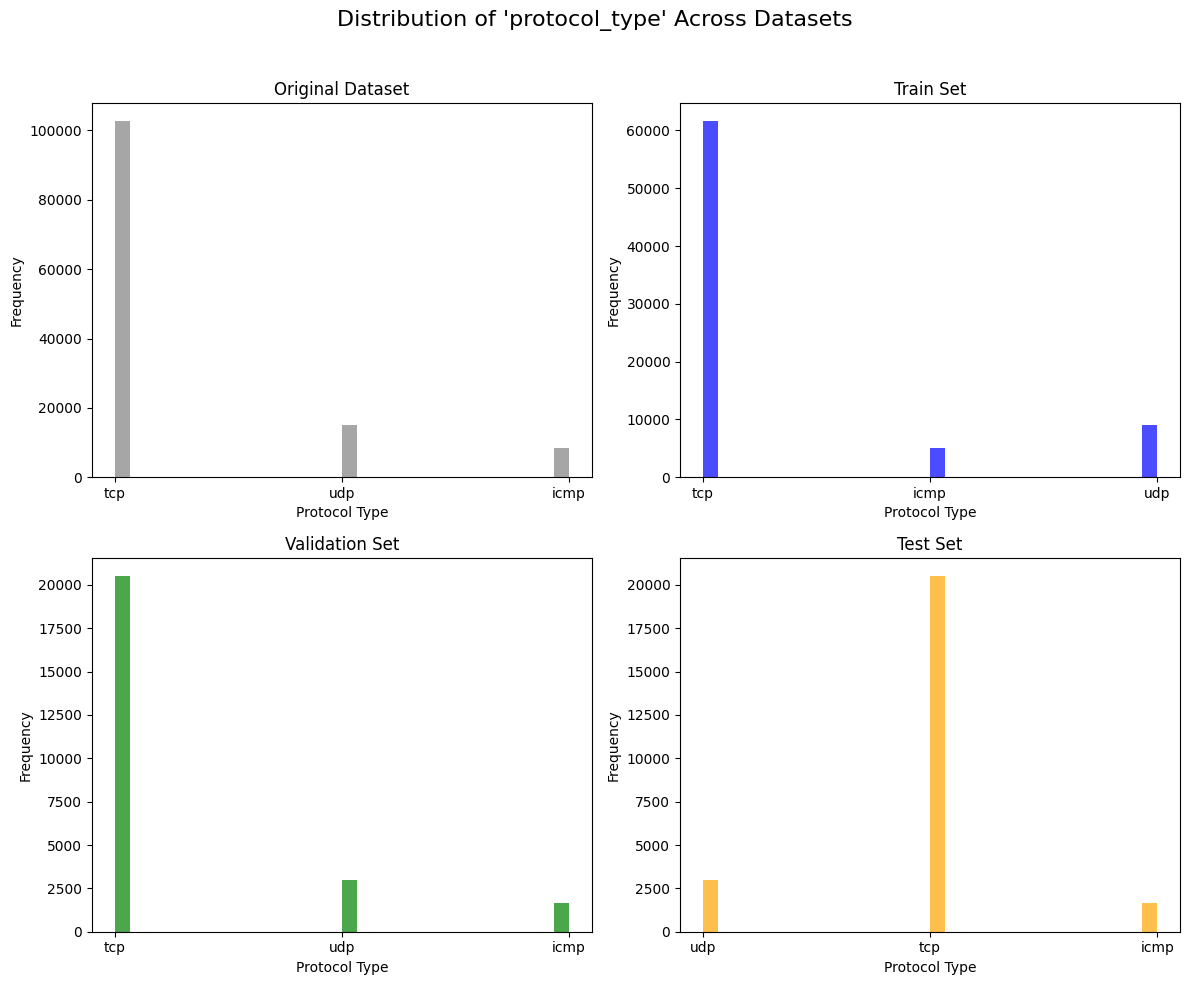

In [90]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12,10))
fig.suptitle("Distribution of 'protocol_type' Across Datasets", fontsize=16)

# Histograma del dataset completo
axes[0,0].hist(df["protocol_type"], bins=30, color='gray', alpha=0.7)
axes[0,0].set_title("Original Dataset")
axes[0,0].set_xlabel("Protocol Type")
axes[0,0].set_ylabel("Frequency")

# Histograma del train set
axes[0,1].hist(train_set["protocol_type"], bins=30, color='blue', alpha=0.7)
axes[0,1].set_title("Train Set")
axes[0,1].set_xlabel("Protocol Type")
axes[0,1].set_ylabel("Frequency")

# Histograma del validation set
axes[1,0].hist(val_set["protocol_type"], bins=30, color='green', alpha=0.7)
axes[1,0].set_title("Validation Set")
axes[1,0].set_xlabel("Protocol Type")
axes[1,0].set_ylabel("Frequency")

# Histograma del test set
axes[1,1].hist(test_set["protocol_type"], bins=30, color='orange', alpha=0.7)
axes[1,1].set_title("Test Set")
axes[1,1].set_xlabel("Protocol Type")
axes[1,1].set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 5. General Conclusion

This phase focused on **splitting the dataset** into training, validation, and test subsets while ensuring representative distributions of categorical variables.

**Key Steps and Achievements:**

1. **Train, Validation, and Test Split**
   - The dataset was divided into three subsets:
     - **Training set:** used to fit the model.
     - **Validation set:** used for tuning hyperparameters and model selection.
     - **Test set:** kept completely separate to evaluate final model performance.
   - Splitting helps prevent **overfitting** (model memorizes training data) and **underfitting** (model fails to learn patterns), ensuring reliable evaluation.

2. **Stratified Sampling**
   - Stratification was applied on `protocol_type` to preserve the proportion of each category across all subsets.
   - This avoids **sampling bias**, which can occur if a subset has too few examples of a particular category.

3. **Visualization of Proportions**
   - Histograms for `protocol_type` in training, validation, and test sets confirm that distributions remain consistent with the original dataset.
   - This ensures that each subset is representative and the model will learn effectively across all categories.

**Key Takeaways:**
- Stratified partitioning guarantees representative samples for categorical features.
- Maintaining correct proportions is critical for accurate model training and evaluation.
- These prepared subsets are ready for the **next steps in machine learning**, including pipeline creation, feature engineering, and model training.